In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import dask.array as da
import cartopy.crs as ccrs
import pyproj
import scipy.linalg as sla
import numpy as np
import verde as vd
import numba
%load_ext line_profiler
%load_ext memory_profiler

In [7]:
data = vd.datasets.fetch_baja_bathymetry()
coordinates = (data.longitude.values, data.latitude.values)
region = vd.get_region(coordinates)
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
proj_coordinates = projection(*coordinates)
spacing = 10 / 60

In [8]:
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing*111e3)
coords, bathy = reducer.filter(proj_coordinates, data.bathymetry_m)
print(bathy.size)

1694


In [4]:
def plot_grid(spline):
    mask = vd.distance_mask(coordinates, maxdist=1, region=region, spacing=spacing)
    grid = spline.grid(
        region=region,
        spacing=spacing,
        projection=projection,
        dims=["latitude", "longitude"],
        data_names=["bathymetry_m"],
    ).where(mask)
    # Cartopy requires setting the coordinate reference system (CRS) of the original data
    # through the transform argument. Their docs say to use PlateCarree to represent
    # geographic data.
    crs = ccrs.PlateCarree()

    plt.figure(figsize=(7, 6))
    # Make a Mercator map of our gridded bathymetry
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_title("Gridded Bathymetry Using Scipy")
    # Plot the gridded bathymetry
    pc = ax.pcolormesh(
        grid.longitude, grid.latitude, grid.bathymetry_m, transform=crs, vmax=0, zorder=-1
    )
    plt.colorbar(pc).set_label("meters")
    # Plot the locations of the decimated data
    #ax.plot(*coordinates, ".k", markersize=0.5, transform=crs)
    # Use an utility function to setup the tick labels and the land feature
    vd.datasets.setup_baja_bathymetry_map(ax)
    plt.tight_layout()
    plt.show()
    return grid

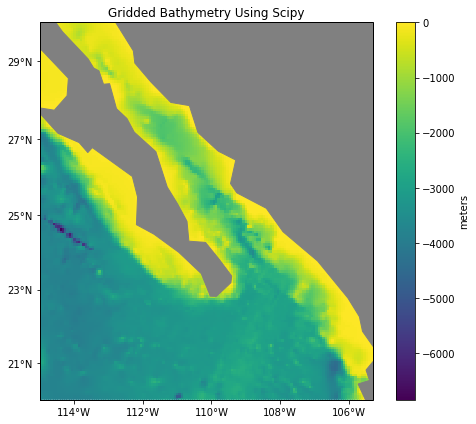

<xarray.Dataset>
Dimensions:       (latitude: 151, longitude: 147)
Coordinates:
  * longitude     (longitude) float64 245.0 245.1 245.1 245.2 245.3 245.3 ...
  * latitude      (latitude) float64 20.0 20.07 20.13 20.2 20.27 20.33 20.4 ...
Data variables:
    bathymetry_m  (latitude, longitude) float64 -3.689e+03 -3.69e+03 ...
Attributes:
    metadata:  Generated by Spline(damping=1e-06, engine='numba', mindist=100...

In [11]:
spline = vd.Spline(damping=1e-6, mindist=100e3, engine="numba").fit(coords, bathy)
plot_grid(spline)

In [5]:
%%time 
vd.Spline(damping=1e-6, mindist=100e3, engine="numpy").fit(coords, bathy)

CPU times: user 54.1 s, sys: 8.93 s, total: 1min 3s
Wall time: 15.8 s


Spline(damping=1e-06, engine='numpy', mindist=100000.0, region=None,
    shape=None, spacing=None)

In [6]:
%%time 
vd.Spline(damping=1e-6, mindist=100e3, engine="numba").fit(coords, bathy)

CPU times: user 53.6 s, sys: 8 s, total: 1min 1s
Wall time: 13 s


Spline(damping=1e-06, engine='numba', mindist=100000.0, region=None,
    shape=None, spacing=None)

In [9]:
%timeit vd.Spline(damping=1e-6, mindist=100e3, engine="numpy").fit(coords, bathy)

446 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit vd.Spline(damping=1e-6, mindist=100e3, engine="numba").fit(coords, bathy)

294 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit vd.Spline(damping=1e-6, mindist=100e3, engine="numpy").jacobian(coords)

158 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit vd.Spline(damping=1e-6, mindist=100e3, engine="numba").jacobian(coords)

18.7 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%lprun -T lprun.txt -f vd.Spline.fit vd.Spline(damping=1e-6, mindist=100e3, engine="numba").fit(coords, bathy)
!cat lprun.txt && rm lprun.txt


*** Profile printout saved to text file 'lprun.txt'. 
Timer unit: 1e-06 s

Total time: 0.389764 s
File: /home/leo/src/verde/verde/spline.py
Function: fit at line 100

Line #      Hits         Time  Per Hit   % Time  Line Contents
   100                                               def fit(self, coordinates, data, weights=None):
   101                                                   """
   102                                                   Fit the biharmonic spline to the given data.
   103                                           
   104                                                   The data region is captured and used as default for the
   105                                                   :meth:`~verde.Spline.grid` and :meth:`~verde.Spline.scatter` methods.
   106                                           
   107                                                   All input arrays must have the same shape.
   108                                           
   109         

In [33]:
%mprun -T mprun.txt -f vd.Spline.fit vd.Spline(damping=1e-6, mindist=100e3, engine="numba").fit(coords, bathy)
!cat mprun.txt && rm mprun.txt



*** Profile printout saved to text file mprun.txt. 
Filename: /home/leo/src/verde/verde/spline.py

Line #    Mem usage    Increment   Line Contents
   100    242.2 MiB    242.2 MiB       def fit(self, coordinates, data, weights=None):
   101                                     """
   102                                     Fit the biharmonic spline to the given data.
   103                             
   104                                     The data region is captured and used as default for the
   105                                     :meth:`~verde.Spline.grid` and :meth:`~verde.Spline.scatter` methods.
   106                             
   107                                     All input arrays must have the same shape.
   108                             
   109                                     Parameters
   110                                     ----------
   111                                     coordinates : tuple of arrays
   112                                   

In [38]:
%mprun -T mprun.txt -f vd.Spline._estimate_forces vd.Spline(damping=1e-6, mindist=100e3, engine="numpy").fit(coords, bathy)
!cat mprun.txt && rm mprun.txt



*** Profile printout saved to text file mprun.txt. 
Filename: /home/leo/src/verde/verde/spline.py

Line #    Mem usage    Increment   Line Contents
   139    495.7 MiB    495.7 MiB       def _estimate_forces(self, jacobian, data, weights):
   140                                     """
   141                                     Estimate forces that fit the data using least-squares. Scales the
   142                                     Jacobian matrix to have unit standard deviation. This helps balance the
   143                                     regularization and the difference between forces.
   144                                     """
   145    495.7 MiB      0.0 MiB           if jacobian.shape[0] < jacobian.shape[1]:
   146                                         warn(
   147                                             " ".join(
   148                                                 [
   149                                                     "Under-determined problem detect